**Imports**

In [1]:
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *

**Load data**

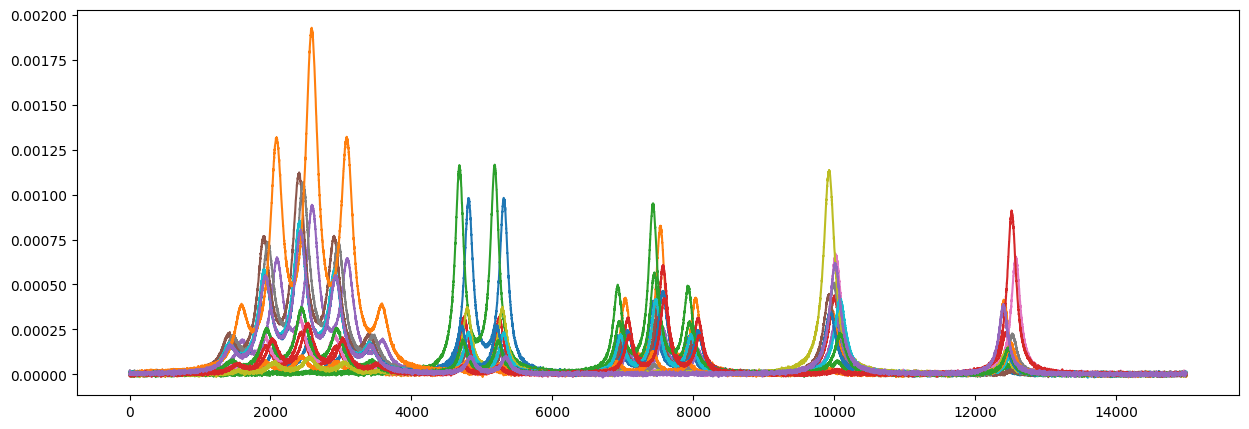

In [2]:
N, M, d = 15, 15000, 5
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V.real

np.random.seed(42)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
# W = np.append(W, [[1,0,0]], axis=0)
# W = np.append(W, [[0,1,0]], axis=0)
# W = np.append(W, [[0,0,1]], axis=0)
# N = N+3

#W = np.random.rand(N, d)
shift = 100
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
tau[W==0] = 0
#set tau to 0 where W is 0

# tau = np.zeros((N,d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
multiplets = 5
#evenly space out means
mean = np.linspace(2500, M-2500, multiplets)
# mean = [1000, 2800, 5000, 6500, 8000]
std = [np.random.randint(70, 120) for _ in range(multiplets)]
t = np.arange(0, M, 1)

H = np.array([multiplet(t, np.random.randint(1,6), m, s, 500)*(np.random.rand()+0.1) for m, s in list(zip(mean, std))])
# H_lorentz = np.array([m(m, s, t) for m, s in list(zip(mean, std))])

X = shift_dataset(W, H, tau)

noise = np.random.normal(0, 5e-6, X.shape)
# noise = np.abs(noise)
X_noisy = X + noise

plt.figure(figsize=(15, 5))
plt.plot(X_noisy.T)
plt.show()

**Fit NMF and extract components**

*TODO* Better component selection.
From jesper, further developed by me

 - Start by fitting n times for 1 component per sample with regularization (maybe bootstrap???)
 - Calculate std
 - Binary search backwards till m found with sample mean lower than (mean+2 * std) from before, where mean of m-1 is higher than (mean+2 * std)
 - That should be the estimated components

epoch: 1500, Loss: 0.010654556752609316, Tau: 4217.2215972130285


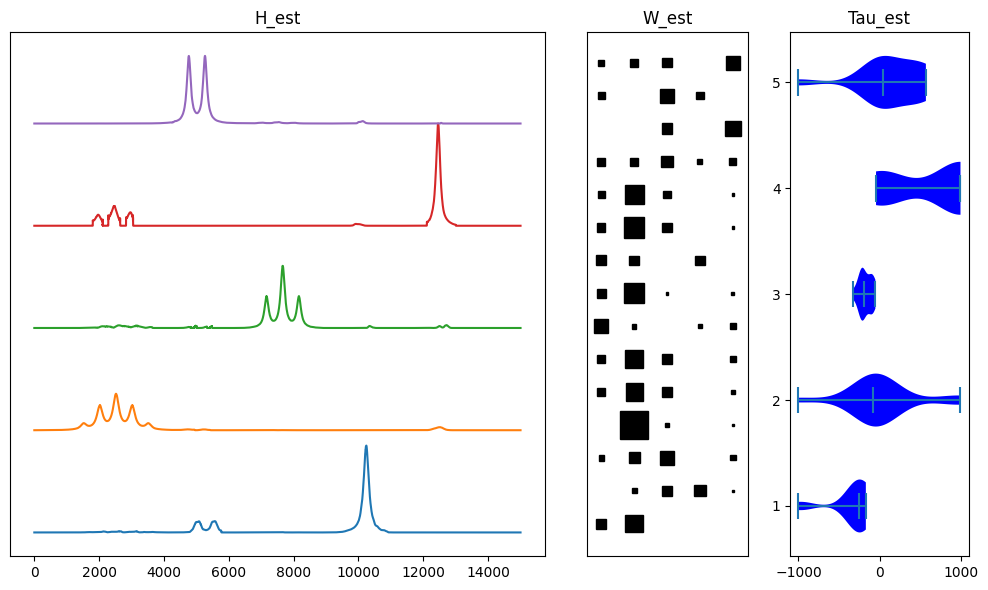

In [3]:
nmf = ShiftNMF(X, 5, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_est,H_est,tau_est, running_loss_hybrid = nmf.fit(verbose=True, return_loss=True, max_iter=1500, tau_iter=0, Lambda=0.1)


def plotSpaced(ax,x,y):
    ymax = y.max()
    yoffset = ymax
    for i in range(y.shape[1]):
        ax.plot(x,y[:,i]+yoffset*i)

    ax.set_yticks([])

def change_violin_colors(violin_parts, color_list):
    for pc, linecolor in zip(violin_parts["bodies"], color_list):
        pc.set_facecolor(linecolor)
        pc.set_alpha(1)


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'black' if w > 0 else 'white'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=False, showmedians=True, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

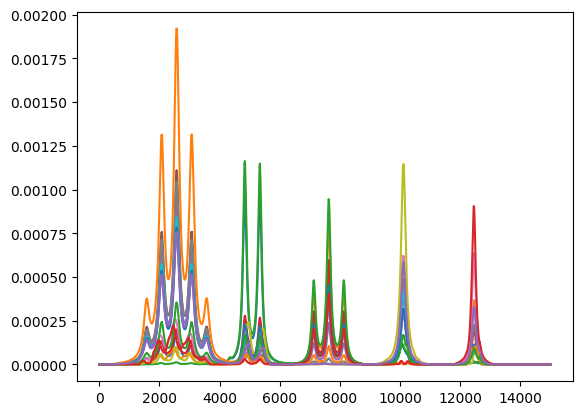

In [4]:
plt.plot(np.matmul(W_est, H_est).T)
plt.show()

**Generate hypothesis from extracted components**

In [4]:
from Hardmodel import Hard_Model
from scipy import stats
from Hardmodel_single_peaks import Single_Model
from scipy.signal import find_peaks_cwt
import scipy
from scipy.signal import find_peaks
import itertools

In [5]:
def single_fit(X):
        alpha = 1e-7
        #find peaks in the sample
        #peaks = find_peaks_cwt(X, widths=[100, 300])
        peaks = find_peaks(X, height=1e-8)[0]
        

        sigmas = scipy.signal.peak_widths(X, peaks, wlen=1000)[0]/2 #.355*1.5
        select = [prom>10 for prom in sigmas]
        select = [i for i, x in enumerate(select) if x == False]
        sigmas = np.delete(sigmas, select)
        peaks = np.delete(np.array(peaks), select)
        print("initial means:")
        print(peaks)
        print("initial sigmas:")
        print(sigmas)
        # peaks,_  = find_peaks(X)
        print("Found peaks:"+str(peaks))
        model = Single_Model(X, peaks, sigmas, lr=5, alpha = alpha, factor=1, patience=1, min_imp=0.001) # min_imp=1e-3)
        W, C = model.fit(verbose=True)

        mean = model.means.detach().numpy()
        sigmas = model.sigma.detach().numpy()
        n = model.N.detach().numpy()

        return mean, sigmas, n

def calc_sigma_matrix(nr_runs=10):
    mean, sigmas = single_fit(X)
    sigma_matrix = np.array([sigmas])
    for i in range(nr_runs-1):
        means, sigmas = single_fit(X)
        sigma_matrix = np.append(sigma_matrix, [sigmas], axis=0)
    return sigma_matrix
    
def calc_difference_matrix(sigmas):
    diff_matrix = np.zeros((len(sigmas),len(sigmas)))
    for i in range(len(sigmas)):
        for j in range(len(sigmas)):
            diff_matrix[i,j] = abs(sigmas[i]-sigmas[j])/sigmas[i]
    return diff_matrix

def peak_hypothesis(value_matrix, cutoff= 5/100):
    H = set()
    for i,peaks in enumerate(value_matrix):
        peaks = peaks.tolist()
        valid_peaks = set()
        for peak_index, peak in enumerate(peaks):
            if peak < cutoff:
                valid_peaks.add(peak_index)
        for combination_length in range(1,len(valid_peaks)+1):
            for h in itertools.combinations(valid_peaks, combination_length):
                H.add(tuple(sorted(h)))
    return H


# means, sigmas, N = [], [], []

# for i in range(len(H_est)):
#     mean, sigma, n = single_fit(H_est[i])
#     means.append(mean)
#     sigmas.append(sigma)
#     N.append(n)

# mean_temp,_  = single_fit(H_est[0])

Prune insignificant means with 0 sigma TODO: Move pruning into model fit to speed up fitting

In [7]:
mean_pruned = []
sigma_pruned = []
for trial in range(len(means)):
    temp_means = []
    temp_sigmas = []
    for i in range(len(means[trial])):
        if sigmas[trial][i] > 10:
            temp_means.append(means[trial][i])
            temp_sigmas.append(sigmas[trial][i])
    
    mean_pruned.append(temp_means)
    sigma_pruned.append(temp_sigmas)

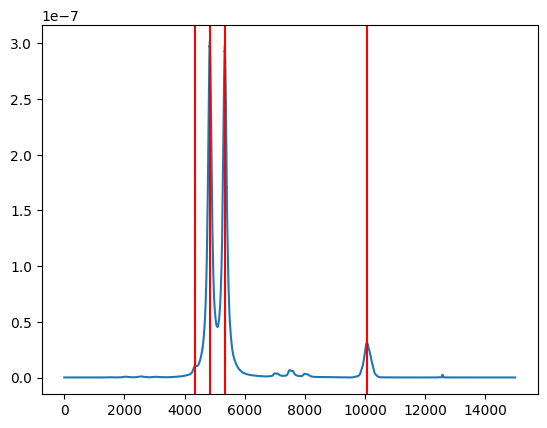

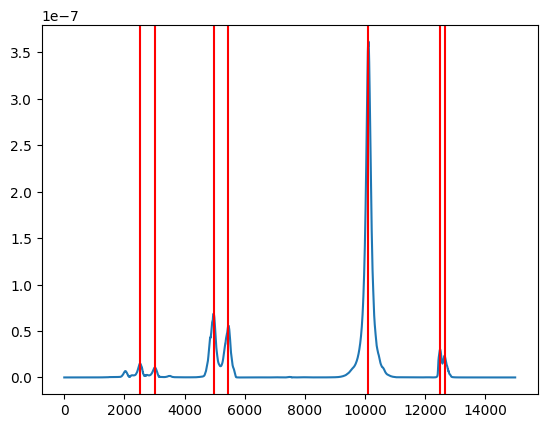

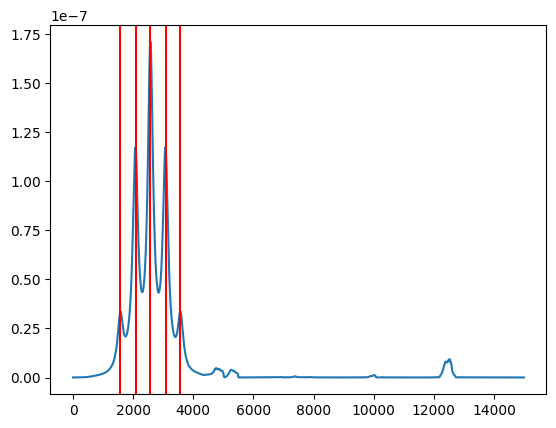

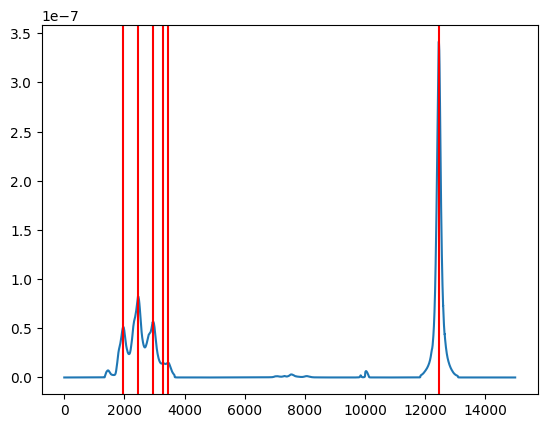

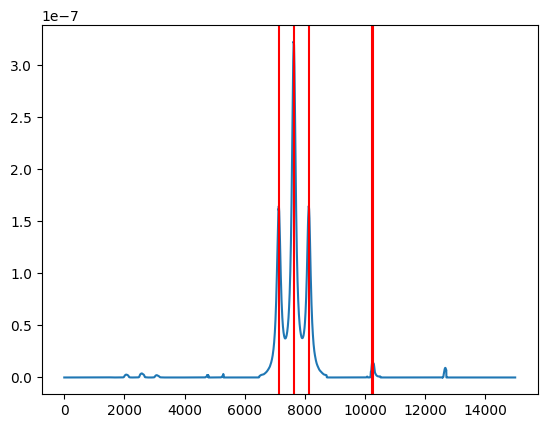

In [8]:
for i in range(len(mean_pruned)):
    plt.plot(H_est[i])
    for mean in mean_pruned[i]:
        plt.axvline(mean, color='r')
    plt.show()

In [9]:
#extract means from mean_pruned and sigmas from sigma_pruned
mean_list = []
for i in range(len(mean_pruned)):
    for j in range(len(mean_pruned[i])):
        mean_list.append(mean_pruned[i][j])

sigma_list = []
for i in range(len(sigma_pruned)):
    for j in range(len(sigma_pruned[i])):
        sigma_list.append(sigma_pruned[i][j])

initial means:
[ 5082  5574 10241]
initial sigmas:
[108.38656179 104.26715308  94.28619912]
Found peaks:[ 5082  5574 10241]
sigma: 114.27045641020354 n:0.44551290951493855
sigma: 103.45042199224605 n:0.35899544221845414
sigma: 90.1496513092904 n:0.017980834375937164
Lorentzian %:s: 0.028029662910675035
tensor([2.0229e-13, 4.1308e-08, 3.9841e-18], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([125.3739,  98.7827,  94.9868], requires_grad=True)
hypothesises:
{(0, 1), (2,), (1, 2), (0, 1, 2), (1,), (0, 2), (0,)}

initial values:
means:
tensor([ 5328.0000, 10241.0000,  6965.6665,  5574.0000,  5082.0000])
sigmas:
Parameter containing:
tensor([112.0783,  94.9868, 106.3811,  98.7827, 125.3739], requires_grad=True)
spacing(J-coupling):
Parameter containing:
tensor([492.,   0., 492.,   0.,   0.], requires_grad=True)
multiplicity:
tensor([2, 1, 3, 1, 1], dtype=torch.int32)
voigt N:
tensor([-23.1156, -40.0642, -28.7652, -17.0022, -29.2291])
epoch: 1, Loss: 0.05412903287799771
ep

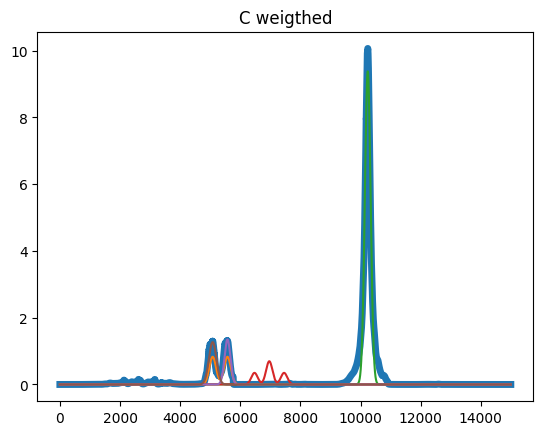

initial means:
[ 1526  2031  2515  3018  3516 12515]
initial sigmas:
[ 62.92430359  78.83403771  88.60951397  78.96008786  62.78137146
 164.34660334]
Found peaks:[ 1526  2031  2515  3018  3516 12515]
sigma: 97.74062683533427 n:0.9304139604291952
sigma: 100.49638896589803 n:0.4858165858076786
sigma: 98.57507384913802 n:3.8706959838858437e-07
sigma: 110.30720325907055 n:0.17135824593466623
sigma: 104.42795402170782 n:0.5477710641209433
sigma: 137.2543567155841 n:0.6523291478209483
Lorentzian %:s: 0.014288087458746815
tensor([1.0000e+00, 7.9164e-11, 8.2449e-10, 4.8955e-14, 1.0000e+00, 3.0158e-14],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([150.6935, 132.4564, 105.6348, 130.6568, 140.9392, 141.2068],
       requires_grad=True)
hypothesises:
{(0, 1, 3, 4), (0, 1, 2, 3, 4, 5), (2,), (0, 1, 4, 5), (3, 4), (0, 2, 3, 5), (5,), (0, 1, 3), (0, 1, 3, 4, 5), (1, 2, 3, 4), (0, 2), (0, 5), (1, 2, 5), (0, 3, 4, 5), (0, 1, 2, 4, 5), (2, 5), (1, 3), (1, 4, 5), (2, 4, 5), (0,

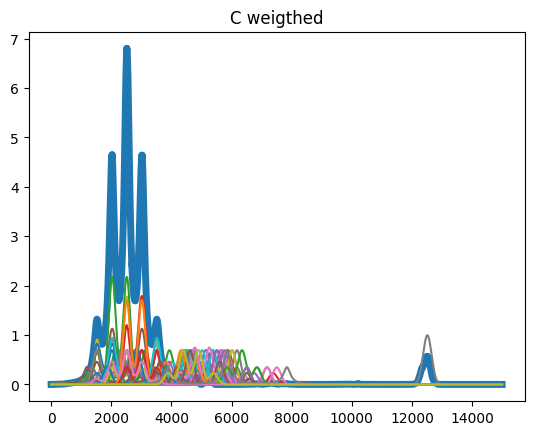

initial means:
[ 2609  3139  3183  4975  7160  7664  8162 12711]
initial sigmas:
[155.29282632 101.79168017  13.40755265  24.46970537  62.9890932
  69.2693386   62.68410772  63.65633752]
Found peaks:[ 2609  3139  3183  4975  7160  7664  8162 12711]
sigma: 259.3360509500043 n:0.18178815648776062
sigma: 120.72976122944527 n:0.999998957288747
sigma: 7.709342813491821 n:0.01798620996209156
sigma: 21.89276635187759 n:0.7221454300348648
sigma: 68.93763534664865 n:0.7667986109042002
sigma: 70.74991305371503 n:1.40295745200329e-05
sigma: 70.24391638571868 n:0.6917169062688902
sigma: 56.682698889060184 n:0.9999950578011668
Lorentzian %:s: 0.015580017512088078
tensor([9.9996e-01, 1.0000e+00, 1.7967e-02, 1.0000e+00, 1.0000e+00, 1.0419e-14,
        1.0000e+00, 1.0000e+00], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([357.6364, 128.6377,   7.7102,  20.6041,  76.7022,  78.6802,  75.7385,
         68.7033], requires_grad=True)
hypothesises:
{(0, 1, 4, 5), (0, 1, 3, 7), (1, 2, 3, 4

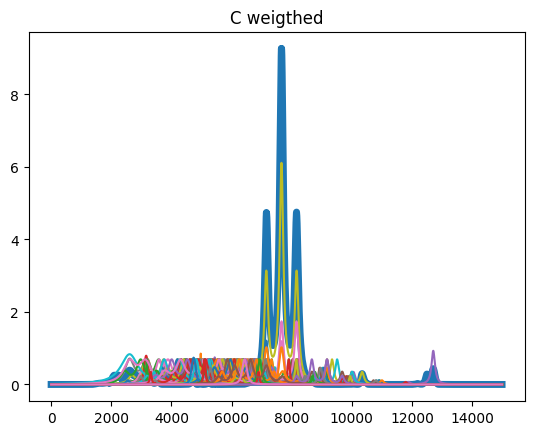

initial means:
[ 1970  2467  2958 12456]
initial sigmas:
[119.30580851 122.13216084 106.5931846   74.73901016]
Found peaks:[ 1970  2467  2958 12456]
sigma: 88.33129943824034 n:0.4035470069799935
sigma: 101.3817216858161 n:0.4043681326875603
sigma: 71.8424129456332 n:0.36104376296810436
sigma: 70.67962037041832 n:0.053022295392177864
Lorentzian %:s: 0.024183861427345124
tensor([3.6825e-11, 1.0068e-11, 3.8936e-14, 5.3737e-17],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([ 83.6746, 102.4071,  63.8594,  72.8214], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}

initial values:
means:
tensor([ 2218.5000,  2958.0000,  2712.5000,  2465.0000,  5631.0000,  5794.6665,
         5960.3335,  2467.0000,  2464.0000,  4962.7500,  1970.0000, 12456.0000])
sigmas:
Parameter containing:
tensor([ 93.0408,  63.8594,  83.1333,  83.3137,  86.3010,  73.4518,  79.6960,


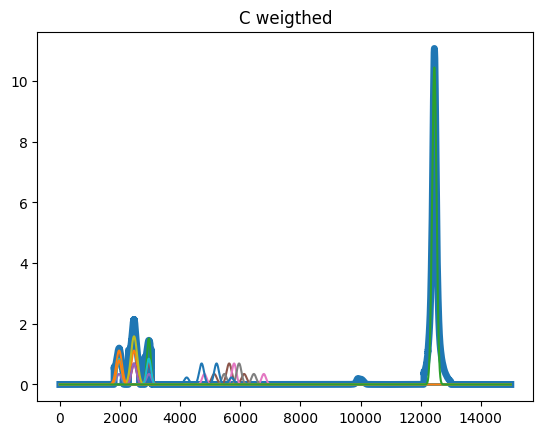

initial means:
[ 4767  5264 10131]
initial sigmas:
[ 64.05295571  64.05730608 103.26074368]
Found peaks:[ 4767  5264 10131]
sigma: 66.25679481400994 n:0.2837755074653647
sigma: 66.92109612020187 n:0.26798643925819143
sigma: 84.83489330012084 n:0.8195807099631484
Lorentzian %:s: 0.033065714738964576
tensor([2.2466e-15, 6.1384e-16, 1.0000e+00], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([80.4940, 81.0393, 84.4274], requires_grad=True)
hypothesises:
{(0, 1), (2,), (1, 2), (0, 1, 2), (1,), (0, 2), (0,)}

initial values:
means:
tensor([ 5015.5000, 10131.0000,  6720.6665,  5264.0000,  4767.0000])
sigmas:
Parameter containing:
tensor([80.7667, 84.4274, 81.9869, 81.0393, 80.4940], requires_grad=True)
spacing(J-coupling):
Parameter containing:
tensor([497.,   0., 497.,   0.,   0.], requires_grad=True)
multiplicity:
tensor([2, 1, 3, 1, 1], dtype=torch.int32)
voigt N:
tensor([-34.3781,  21.1406, -15.8719, -35.0268, -33.7294])
epoch: 1, Loss: 0.04868500996886988
epoch: 2, Loss

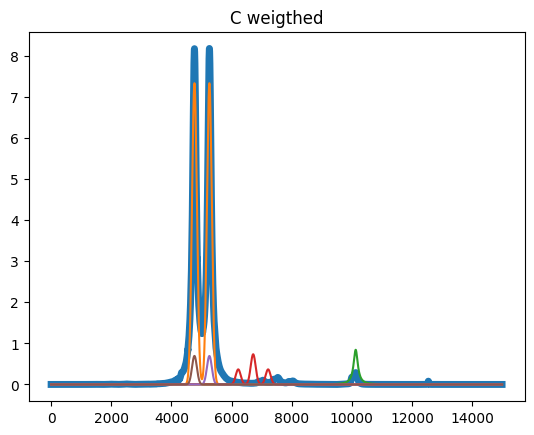

In [17]:
import importlib
import Hardmodel
importlib.reload(Hardmodel)
from Hardmodel import Hard_Model

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()

In [31]:
diff_matrix = calc_difference_matrix(sigma_list)
hypothesis = peak_hypothesis(diff_matrix)

X_aligned = np.matmul(W_est, H_est)

hardmodel = Hard_Model(X_aligned, hypothesis, mean_list, sigma_list, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
W, C = hardmodel.fit(verbose=True)

plt.plot(hardmodel.X.detach().numpy())
print("W:")
print(W)
for i, vec in enumerate(C):
    plt.plot(vec*W[:,i])
plt.title("C")
plt.show()

plt.plot(hardmodel.X.detach().numpy())
plt.plot(np.matmul(W,C).T)
plt.show()

initial values:
tensor([ 8989.6670,  3641.5000,  2803.0000,  9938.0000,  7591.0000,  8039.0000,
         5574.6665,  5072.2500,  4097.5000,  8764.7500,  3692.0000,  3450.3333,
         2070.0000,  4140.5000,  5249.0000,  5916.0000,  8371.6670,  5001.3335,
         2569.0000,  6622.3335,  1565.0000,  3068.0000,  3284.6667,  7592.0000,
         9688.5000,  6807.3335,  7927.2500,  3999.6667,  2556.0000,  4303.0000,
         4740.0000, 10269.0000, 10187.5000,  3724.6667,  3230.5000,  9322.3330,
         7327.0000,  4332.3335,  8176.7500,  6878.5000,  2761.0000,  4948.0000,
         5733.7500,  3393.0000,  5734.0000,  7342.0000,  9902.0000,  3972.5000,
         3393.0000,  7841.0000,  5213.0000,  1573.0000,  3890.5000,  3393.0000,
         5968.0000,  4744.0000,  8205.6670,  6235.5000,  7959.7998,  7624.0000,
         6415.0000,  8326.3330,  3892.0000,  4440.6665,  7355.0000, 12285.0000,
        11357.5000,  2568.0000,  3725.6667,  7092.0000,  6467.0000,  4000.0000,
         6503.0000,  548

KeyboardInterrupt: 

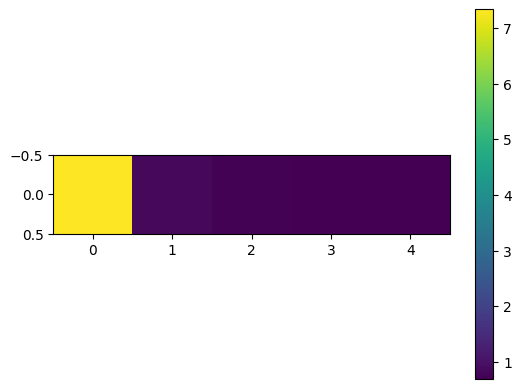

In [18]:
plt.imshow(W)
plt.colorbar()
plt.show()

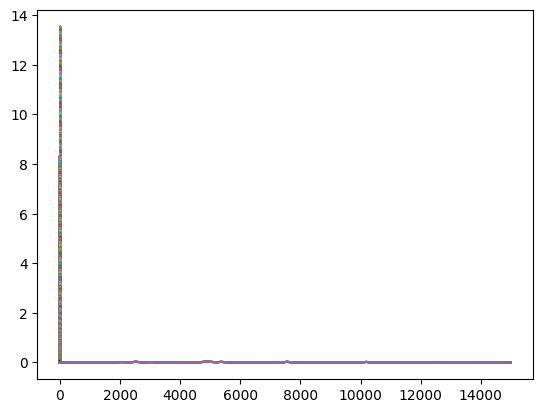

In [ ]:
plt.plot(hardmodel.X.detach().numpy())
plt.plot(np.matmul(W,C).T)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from helpers.callbacks import ChangeStopper, ImprovementStopper
from helpers.losses import frobeniusLoss, VolLoss
import scipy
import numpy as np
from nnls_l1 import nnls

class Hard_Model(torch.nn.Module):
    def __init__(self, X, H, peak_means, peak_sigmas, alpha=1e-6, lr=0.1, patience=5, factor=1, min_imp=1e-6):
        super().__init__()
        means = []
        mult = []
        sigma = []
        J_coup = []

        for hyp in H:
            means.append(np.mean([peak_means[i] for i in hyp]))
            mult.append(len(hyp))
            sigma.append(np.mean([peak_sigmas[i] for i in hyp]))
            if len(hyp) > 1:
                J_coup.append(peak_means[hyp[1]]-peak_means[hyp[0]])
            else:
                J_coup.append(1000)


        rank = len(means)
        self.X = torch.tensor(X)
        if len(X.shape) == 1:
            self.X = torch.unsqueeze(self.X,dim=0)
            n_row = 1
            n_col = X.shape[0]
            
        n_row, n_col = X.shape
        self.softplus = torch.nn.Softplus()
        self.softmax = torch.nn.Softmax()
        self.n_row = n_row # nr of samples
        self.n_col = n_col
        self.rank = rank
        
        
        self.std = torch.std(self.X)
        self.X = self.X/self.std
        
        self.lossfn = frobeniusLoss(self.X.clone().detach())
        
        # Initialization of Tensors/Matrices a and b with size NxR and RxM
        #Weights of each component
        self.W = torch.nn.Parameter(torch.rand(n_row, rank, requires_grad=True))
        self.sigma = torch.nn.Parameter(torch.tensor(sigma, requires_grad=True,dtype=torch.float32))
        self.spacing = torch.nn.Parameter(torch.tensor(J_coup, requires_grad=True,dtype=torch.float32))
        self.means = torch.tensor(means,dtype = torch.float32)
        print("initial values:")
        print(self.means)
        print(self.sigma)
        print(self.spacing)

        self.multiplicity = torch.tensor(mult,dtype=torch.int32)
        print(self.multiplicity)
        print(self.multiplicity[0])
        #self.multiplicity = torch.tensor([2,2,2])
        
        #self.H = torch.nn.Parameter(torch.randn(rank, n_col, requires_grad=True))
        #After calculation should end up with the following dimensions: rank * n_col

        # print(torch.mean(self.X, dim=0).shape

        self.optimizer = Adam(self.parameters(), lr=lr)
        
        self.stopper = ChangeStopper(alpha=alpha, patience=patience)
        self.improvement_stopper = ImprovementStopper(min_improvement=min_imp, patience=patience)
        
        # self.w_optimizer = Adam([self.W], lr=lr)
        self.peak_position_optimizer  = Adam([self.means], lr=lr)
        self.all_peak_optimizer = Adam([self.means, self.sigma, self.spacing], lr=lr)
        
        if factor < 1:
            self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=factor, patience=patience-5)
        else:
            self.scheduler = None

    def pascal(self, x):
        triangle = torch.zeros((x, x))
        for i in range(x):
            triangle[i, 0] = 1
            triangle[i, i] = 1
            if i > 0:
                for j in range(1, i):
                    triangle[i, j] = triangle[i - 1, j - 1] + triangle[i - 1, j]
        return triangle[-1]

    def lorentzian(self, x, mean, variance):
        #print(variance) nan problem was the variance
        return 1 / (torch.pi * variance * (1 + ((x - mean) / variance) ** 2))
    def gauss(self, x, mean, variance):
        return 1/(variance*(2*torch.pi)**(1/2))*torch.exp(-1/2*((x-mean)/variance)**2)

    def multiplet(self, x, mult, mean, sigma, spacing, type='lorentz'):
        triangle = self.pascal(mult)
        t_max = torch.max(triangle)
        triangle = triangle/t_max
        y = torch.zeros(len(x),dtype=float)

        if mult%2 == 0:
            space = -1*mult/2*spacing+spacing/2
        else:
            space = -1*(mult-1)/2*spacing
        for i,size in enumerate(triangle):
            if type == 'lorentz':
                y += self.lorentzian(x, mean+space, sigma)*size
            else:
                y += self.gauss(x, mean+space, sigma)*size
            space +=  spacing
        return y

    def forward(self):
        time = torch.linspace(0,self.n_col,self.n_col)
        self.C = torch.zeros((self.rank, self.n_col))
        
        for i in range(self.rank):
            self.C[i] += self.multiplet(time,
                                    self.multiplicity[i],
                                    self.means[i],
                                    torch.clamp(self.sigma[i],1),
                                    self.softplus(self.spacing[i]),
                                    type="lorentz")
        
        WC = torch.matmul(self.softplus(self.W), self.C) #self.softplus(self.C))
        return WC
    
    def fit_grad(self, grad):
        stopper = ChangeStopper(alpha=1e-3, patience=3)
        improvement_stopper = ImprovementStopper(min_improvement=1e-3, patience=3)

        while not stopper.trigger() and not improvement_stopper.trigger():
            grad.zero_grad()
            output = self.forward()
            loss = self.lossfn.forward(output)
            print(f"Loss: {loss.item()}", end='\r')
            loss.backward()
            grad.step()
            stopper.track_loss(loss)
            improvement_stopper.track_loss(loss)
        print(f"Loss: {loss.item()}")

    def fit(self, verbose=False, return_loss=False):
        running_loss = []
        iters = 0

        while not self.stopper.trigger() and not self.improvement_stopper.trigger():
            if (self.improvement_stopper.trigger()):
                print(self.improvement_stopper.trigger())
            # self.fit_grad(self.w_optimizer)
            
            iters +=1
            #fit W by nnls
            if iters > 1:
                print('\n fitting W \n')
                #copy W to numpy
                W_pre = self.W.detach().numpy()
                W_new = torch.zeros(W_pre.shape)
                
                for i in range(self.n_row):
                    C_T = self.C.T.detach().numpy()
                    X_i = self.X[i].detach().numpy()
                    
                    W = nnls(C_T, X_i[i], alpha=0.1, x0 = W_pre[i])
                    
                    W_new[i] = torch.tensor(W)
                
                self.W = torch.nn.Parameter(W_new)
            
            self.fit_grad(self.optimizer)
            # # forward
            output = self.forward()

            #loss calc
            loss = self.lossfn.forward(output)
            loss.backward()
            # # Update
            #self.optimizer.step()
    
            if self.scheduler != None:
                self.scheduler.step(loss)

            running_loss.append(loss.item())
            self.stopper.track_loss(loss)
            self.improvement_stopper.track_loss(loss)

            # print loss
            if verbose:
                print(f"epoch: {len(running_loss)}, Loss: {loss.item()}")
                # print(f"epoch: {len(running_loss)}, Loss: {loss.item()}", end='\r')

        W = self.softplus(self.W).detach().numpy()
        C = self.C.detach().numpy()
        print(self.means)
        print(self.softplus(self.sigma))
        print(self.multiplicity)
        print(self.softplus(self.spacing))
        if return_loss:
            return W, C, running_loss
        else:
            return W, C
